# 最終発表

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# モジュールの読み込み
import sys
sys.path.append('./module')
from utils import plot_error_KF, estimate_error_with_params
from localization import plot_gaspari_cohn


/Users/sakajokenkyusitutakeda/.pyenv/versions/anaconda3-2020.02/envs/startup/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 内容
- 自己紹介
- 進捗
- 振り返り

# 自己紹介
竹田航太

所属: 京都大学 大学院理学研究科 数学教室 坂上研究室

学年: 1年

専攻: 応用数学

興味: 流体，UQ(Uncertainty Quantification)， 機械学習, データ同化，気象予報

# 進捗

## Localization
遠くの観測の影響を小さくする．

### Gaspari Cohn
- Gspari Cohn funtion $ G_c(x, c) $はGaussianを近似した区分的有理関数．
- Gaussianとの違いはある点以降で真に0になること．
- https://journals.ametsoc.org/mwr/article/139/7/2046/71368/On-Domain-Localization-in-Ensemble-Based-Kalman

### gaspari cohn vs gaussian
パラメータの対応関係．以下の対応がある．

$ G_c(x, c) \leftrightarrow \exp(- \frac{x^2}{2L^2}) $

ただし，$ L = c(0.3)^{1/2} $

In [5]:
def gaspari_cohn_gaussian(c):
    L = c*(0.3)**(1/2)
    plot_gaspari_cohn(c)
    x_arr = np.linspace(0, 20, 100)
    y_func = [np.exp(-x**2/(2*L**2)) for x in x_arr]
    plt.plot(x_arr, y_func, label='gassian')
    _ = plt.legend()
    print('c: {}, L: {}'.format(c, L))

c: 5, L: 2.73861278752583


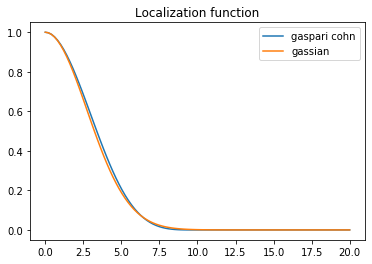

In [8]:
c = 5
gaspari_cohn_gaussian(c)

## LETKF(Local Ensemble Transform Kalman Filter)

### アルゴリズム
$ \tilde{P^a} = [(N-1)I/\alpha + dY^T R^{-1} dY]^{-1} \in \mathbb{R}^{m \times m}$

$ T = \tilde{P^a} dY^T R^{-1}(y^o - \overline{dY^f}) + [(N-1) \tilde{P^a}]^{1/2}  \in \mathbb{R}^{m \times m}$

$ X^a = x^f + dX^f T$

iteration:
- 各観測で状態変数の数N=40回
- 各i(in 1~40)で
    - x_iを推定．
    - x_iに近い観測を用いる．-> localization
    
localization:
- R-locで実装．R-inverseにlocal functionをかける．
- local functionとしてgaspari cohn functionを採用．

### 実装方法
せっかくなので遠回りして2通りで実装．
1. ETKFの拡張
    - 方法: 
      - 各時刻で40回同化．
      - $i$番目の$x^a$を$i+1$番目の$x^f(x^b)$とする． 
      - 各時刻では$i$番目の変数の両隣を含めた3次元状態空間で推定．
    - 特徴:
      - 各時刻では$N=40$より小さい3次元状態空間で計算しているので速い．
      - 相対的に精度が悪い．
    
2. LETKFを改めて実装
    - 方法:
      - 各時刻で40回同化．
      - 各時刻で独立して状態変数の$x_i$を推定. -> これを採用
    - 特徴:
      - 各時刻で$N=40$次元で推定を行う．
      - 相対的に精度が良い．
      - 並列化できる．

### パラメータ探索
inflation factor $\alpha$とlocalization scale $c$の2次元でパラメータ探索を行う．
- inflation:
    - $ dX \rightarrow \sqrt{\alpha}dX $
- localiztion:
    - Gaspari Cohn function $ G_c(x, c) $. $ |x| > 2c $では0になる．

Text(69.0, 0.5, 'alpha')

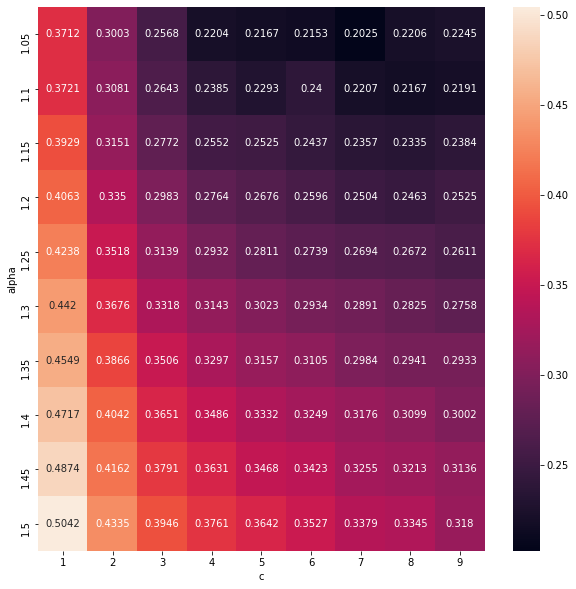

In [17]:
df = pd.read_csv('data/letkf/letkf_alpha_c_rough.csv', index_col=0, header=0)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df.iloc[1:, :9], annot=True, fmt='.4g')
ax.set_xlabel('c')
_ = ax.set_ylabel('alpha')

### 現状の最適なLETKFの結果
パラメータ
- $ alpha = 1.06 $
- $ c = 8.2 $

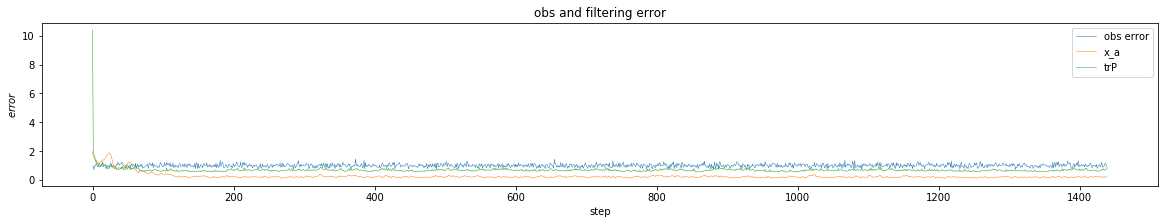

rmse: 0.2037757543072912


In [32]:
# 観測値と真値
y = np.load('data/obs_atr.npy')
true = np.load('data/true_atr.npy')

x, trP = np.load('data/letkf/letkf_optimal.npy', allow_pickle=True)

plot_error_KF(true, y, [x], trPs=[trP], legends=['x_a', 'x_f'])
_, _, rmse = estimate_error_with_params(true, [x], [8], 'm', plot=False)
_ = print('rmse: {}'.format(rmse))

## KFの比較
実行時間とRMSE


### 設定
- 全点観測
- 1年分(360*4 step)のうち，200 stepをspin upして，RMSEの時間平均を比べる．
- それぞれの方法で現状最適な結果を採用．

### エントリー
- ExKF
- 3DVar
- PO40
- SRF40
- SRF20
- LETKF8

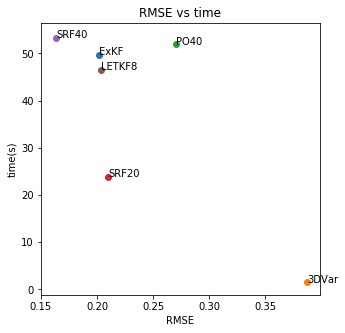

In [3]:
# TODO:整理し直す．
labels = np.array(['ExKF', '3DVar', 'PO40', 'SRF20', 'SRF40', 'SRF50', 'LETKF8']) # LETKF8, LETKF40追加
rmses = np.array([0.2018, 0.3871, 0.2705, 0.2099, 0.1636, 0.1679, 0.2037])
times = np.array([49.6, 1.49, 51.9, 23.9, 53.2, 122, 46.5])
fig, ax = plt.subplots(figsize=(5,5))
index = [0,1,2,3,4,6]
for i in range(len(labels[index])):
    idx = index[i]
    ax.scatter(rmses[idx], times[idx])
    ax.text(rmses[idx], times[idx], labels[idx])

ax.set_xlabel('RMSE')
ax.set_ylabel('time(s)')
_ = plt.title('RMSE vs time')

# scores = [1/x for x in rmses**3*times**0.5]
# fig1, ax1 = plt.subplots()
# ax1.bar(range(len(labels)), scores, tick_label=labels)
# plt.title('score')

## 課題
- パラメータチューニングが不完全
- LETKFの実行速度が遅い， 精度が悪い．

## これから
- addaptive inflation
- 並列化

# 振り返り

## 今回の目的
- データ同化の実践的理論の学習．
- 理論 $ \rightarrow $ 実践の展開
- 大自由度系の数値計算に関する知識の獲得．
- Kalman Filterの実装．

## 背景知識
- Introduction to UQ(数学の本)
- Kalman Filterに関する知識．
    - 変分的な枠組みで導出をした．
    - ざっくりとLKF, ExKF, EnKFのアルゴリズム．

## 学んだこと
- データ同化に関して
    - データ同化の理論についての復習と新たな発見．
    - additive inflationをしない理由がわかった．
    - チューニングの重要性．
- 細かい実装
    - 実装方法の選択．
    - 行列計算では言語やライブラリの仕様に気をつける．
        - ExKFの線形化コード
        - アンサンブルの表現
        - LETKFのTransform
- 他の人との関わり
    - 他の人の発表方法は参考になる．
    - 他の人が書いたコードを見るのも勉強になる．
- その他
    - 可視化の重要性